In [22]:
import numpy as np
import pandas as pd
import math
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

In [23]:
# Define x and y coordinates
xcordinate = np.array([151, 159, 130, 128, 163, 146, 161, 142, 163, 148, 128, 156, 129, 146, 164, 141, 147, 164, 129, 155, 139])
ycordinate = np.array([264, 261, 254, 252, 247, 246, 242, 239, 236, 232, 231, 217, 214, 208, 208, 206, 193, 193, 189, 185, 182])

# Define demand for each point
demand = np.array([1100, 700, 800, 1400, 2100, 400, 800, 100, 500, 600, 1200, 1300, 1300, 300, 900, 2100, 1000, 900, 2500, 1800, 700])


In [24]:
# Create a DataFrame for demand
dem = pd.DataFrame({'demand': demand})
d = dem[dem.columns[0]]
d.index = np.arange(1, len(dem) + 1)

In [25]:
# Create a DataFrame for coordinates
df = pd.DataFrame({"X": xcordinate, "Y": ycordinate})
x_c = df[df.columns[0]]
y_c = df[df.columns[1]]
x_c.index = np.arange(1, len(x_c) + 1)
y_c.index = np.arange(1, len(y_c) + 1)

In [26]:
# Number of vehicles and stops
vehicles = 5
n_stops = 21
dem_points = list(range(1, n_stops + 1))

# Create a complete directed graph
G = nx.complete_graph(n_stops + 1, nx.DiGraph())

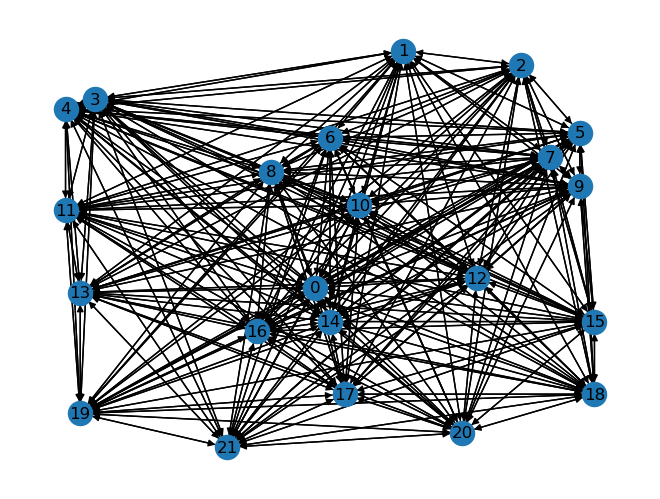

In [27]:
# Define positions for nodes
my_pos = {i: (x_c[i], y_c[i]) for i in dem_points}
depot = 0 
my_pos[depot] = (145, 215)

# Draw the graph
nx.draw(G, pos=my_pos, with_labels=True)

In [28]:
# Define a function for Euclidean distance
def eucl_dist(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Calculate edge lengths using Euclidean distance
for i, j in G.edges:
    (x1, y1) = my_pos[i]
    (x2, y2) = my_pos[j]
    G.edges[i, j]['length'] = eucl_dist(x1, y1, x2, y2)

In [29]:
# Define capacity and demand data
Q = 6000
q = {i: d[i] for i in dem_points}

In [30]:
# Create a Gurobi model
m = gp.Model()

# Define binary decision variables for edges
x = m.addVars(G.edges, vtype=GRB.BINARY)

# Set the objective function to minimize distance
m.setObjective(gp.quicksum(G.edges[i, j]['length'] * x[i, j] for i, j in G.edges), GRB.MINIMIZE)

# Constraints:

# Each demand point is visited once
m.addConstrs(gp.quicksum(x[i, j] for i in G.predecessors(j)) == 1 for j in dem_points)

# Each demand point is left once
m.addConstrs(gp.quicksum(x[i, j] for j in G.successors(i)) == 1 for i in dem_points)

# Number of vehicles leaving and returning to the depot
m.addConstr(gp.quicksum(x[depot, j] for j in G.successors(depot)) <= vehicles)
m.addConstr(gp.quicksum(x[j, depot] for j in G.successors(depot)) <= vehicles)

# Define decision variables for load at each node
u = m.addVars(G.nodes)
u[depot].LB = 0
u[depot].UB = 0

for i in dem_points:
    u[i].LB = q[i]
    u[i].UB = Q

# Capacity constraints
q[depot] = 0
m.addConstrs(u[i] - u[j] + Q * x[i, j] + (Q - q[i] - q[j]) * x[j, i] <= Q - q[j] for i, j in G.edges if j != depot)

# Optimize the model
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 485 rows, 484 columns and 2688 nonzeros
Model fingerprint: 0xefb270ab
Variable types: 22 continuous, 462 integer (462 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [3e+00, 8e+01]
  Bounds range     [1e+00, 6e+03]
  RHS range        [1e+00, 6e+03]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 485 rows, 483 columns, 2667 nonzeros
Variable types: 21 continuous, 462 integer (462 binary)
Found heuristic solution: objective 946.3415706

Root relaxation: objective 2.619793e+02, 113 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  261.97931    0   45  946.34157  261.97931  72.3%     -    0s


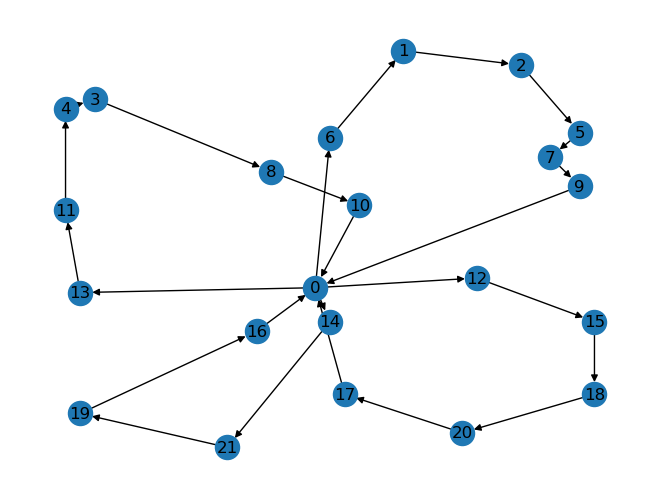

In [31]:
# Get the solution and draw it
tour_edges = [e for e in G.edges if x[e].x > 0.99]
nx.draw(G.edge_subgraph(tour_edges), pos=my_pos, with_labels=True)


In [32]:
# Print information about the optimization method and whether it's a MIP
print(m.getParamInfo('Method'))
m.IsMIP

('Method', <class 'int'>, -1, -1, 5, -1)


1